In [121]:
import pandas as pd
import nibabel as nib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.append('..')
import sfp
import pyPyrTools as ppt
import math
from scipy import stats
from scipy import optimize as opt

In [6]:
df = pd.read_csv("/home/billbrod/Data/spatial_frequency_preferences/derivatives/first_level_analysis/stim_class/posterior/sub-wlsubj045/ses-02/sub-wlsubj045_ses-02_task-sfp_v1-2-3_e1-12_no_bin_summary.csv")

In [24]:
# Pick a V1 voxel with a good R2
voxel_df = df[(df.voxel==8014)]

In [101]:
voxel_eccen = voxel_df.eccen.unique()[0]
voxel_angle = math.radians(voxel_df.angle.unique()[0])
angle = ppt.mkAngle(1080)
R = ppt.mkR(1080) * (24 / 1080.)
angle_dist = abs(angle - voxel_angle)
angle_dist /= angle_dist.max()
eccen_dist = abs(R - voxel_eccen)
eccen_dist /= eccen_dist.max()
flattened_idx = (angle_dist+eccen_dist).argmin()
twod_resp = []
for i, row in voxel_df.iterrows():
    dx, dy, _, _ = sfp.stimuli.create_sf_maps_cpp(1080, w_r=row.w_r, w_a=row.w_a)
    dx /= (24 / 1080.)
    dy /= (24 / 1080.)
    twod_resp.append((dx.flatten()[flattened_idx], dy.flatten()[flattened_idx], row.amplitude_estimate_median))
twod_resp = np.array(twod_resp)

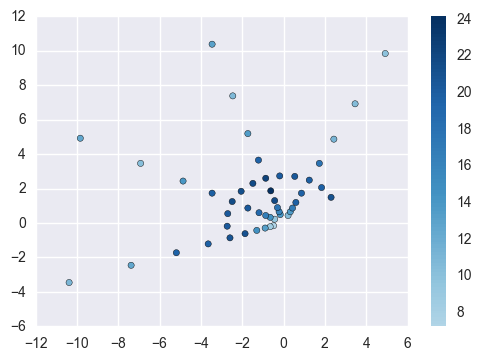

In [106]:
plt.scatter(twod_resp[:,0], twod_resp[:,1], c=twod_resp[:,2],cmap='RdBu', norm=sfp.plotting.MidpointNormalize(midpoint=0)) 
plt.colorbar()

In [168]:
def twoD_Gaussian((x, y), amplitude, mu_x, mu_y, sig_xx, sig_xy, sig_yx, sig_yy):
    twod_gauss = stats.multivariate_normal(mean=(mu_x, mu_y), cov=[[sig_xx, sig_xy],[sig_yx, sig_yy]])
    xgrid, ygrid = np.meshgrid(x, y)
    X = np.empty(xgrid.shape + (2,))
    X[:,:,0] = xgrid
    X[:,:,1] = ygrid
    gauss_resp = twod_gauss.pdf(X)
    gauss_resp /= gauss_resp.max()
    return amplitude * gauss_resp
def fit_twoD_Gaussian(*args, **kwargs):
    return np.diagonal(twoD_Gaussian(*args, **kwargs))

In [172]:
x= twod_resp[:,0]
y=twod_resp[:,1]
popt, pcov = opt.curve_fit(fit_twoD_Gaussian, (x, y), twod_resp[:,2], p0=(20, 0, 0, 1, 0, 0, 1))

In [178]:
popt

array([19.99936831, -2.63136983,  2.33924012, 64.07908757,  0.        ,
       24.31571838, 38.9081664 ])

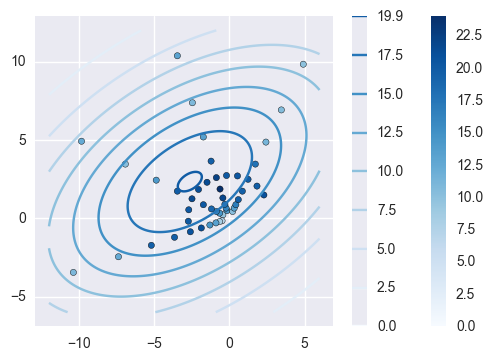

In [181]:
x = np.linspace(-12, 6, 1000)
y = np.linspace(-6, 12, 1000)
plt.scatter(twod_resp[:,0], twod_resp[:,1], c=twod_resp[:,2],cmap='Blues', vmin=0, vmax=24)
plt.colorbar()
plt.contour(x, y, twoD_Gaussian((x, y), *popt), aspect='equal', cmap='Blues', vmin=0, vmax=24, levels=[0, 2.5, 5, 7.5, 10, 12.5, 15, 17.5, 19.9])
plt.colorbar()
plt.savefig('model.pdf')